In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = '../dl1/data/dogscats/'
sz = 224

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['sample', 'train', 'valid', 'test1', 'models']

In [7]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [8]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.1195.jpg',
 'cat.7838.jpg',
 'cat.12332.jpg',
 'cat.10127.jpg',
 'cat.3710.jpg']

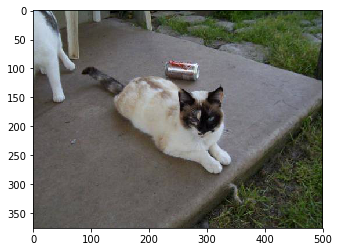

In [9]:
img = plt.imread(f'{PATH}/valid/cats/{files[0]}')
# img = plt.imread(f'{PATH}/valid/cats/cat.1001.jpg')
plt.imshow(img)

In [10]:
img.shape

(376, 500, 3)

In [11]:
img[:4, :4]

array([[[168, 199, 228],
        [167, 197, 225],
        [164, 194, 222],
        [163, 190, 217]],

       [[176, 206, 234],
        [174, 204, 232],
        [174, 201, 228],
        [173, 199, 224]],

       [[183, 211, 235],
        [183, 209, 234],
        [181, 207, 232],
        [182, 206, 230]],

       [[184, 209, 231],
        [183, 208, 230],
        [184, 206, 229],
        [185, 207, 228]]], dtype=uint8)

In [19]:
arch = resnet34
data = ImageClassifierData.from_paths(path=PATH, tfms=tfms_from_model(arch, sz))
# learn = ConvLearner.pretrained(arch, data, precompute=True)
# learn.fit(0.01, 2)

In [20]:
data.classes

['cats', 'dogs']

In [21]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [15]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [16]:
log_preds[:10]

array([[ -0.03664,  -3.32477],
       [ -0.00002, -10.72561],
       [ -0.00015,  -8.79122],
       [ -0.00003, -10.32783],
       [ -0.00106,  -6.85147],
       [ -0.00014,  -8.85791],
       [ -0.00004, -10.20236],
       [ -0.00003, -10.45849],
       [ -0.00971,  -4.63973],
       [ -0.00008,  -9.43004]], dtype=float32)

In [17]:
preds = np.argmax(log_preds, axis=1)
preds[:5]

array([0, 0, 0, 0, 0])

In [18]:
probs = np.exp(log_preds[:, 1])
probs[:5]

array([0.03598, 0.00002, 0.00015, 0.00003, 0.00106], dtype=float32)

In [19]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)

In [20]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [21]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


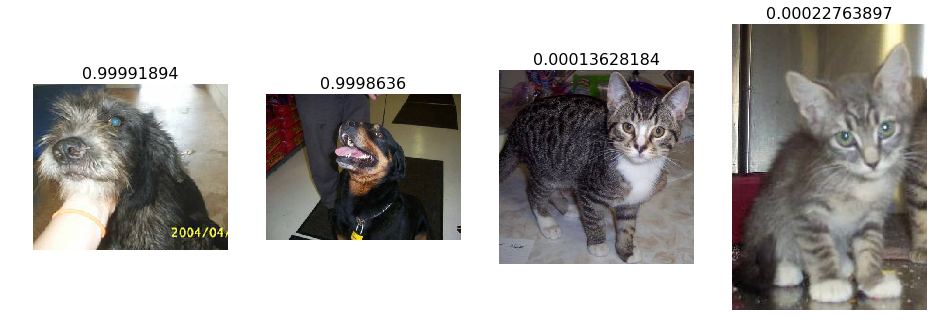

In [22]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classfied


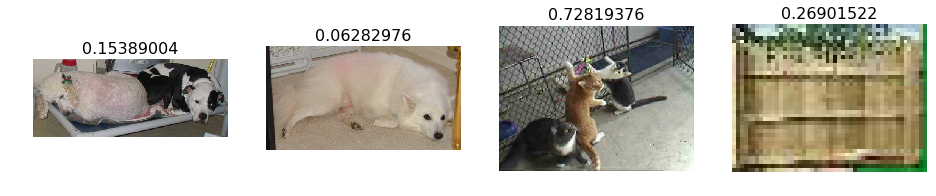

In [23]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classfied")

In [24]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most Correct Cats


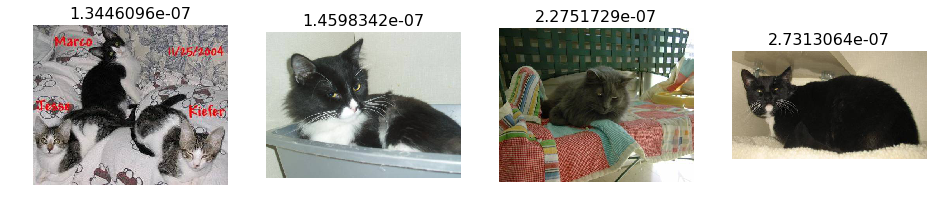

In [25]:
plot_val_with_title(most_by_correct(0, True), "Most Correct Cats")

Most correct Dogs


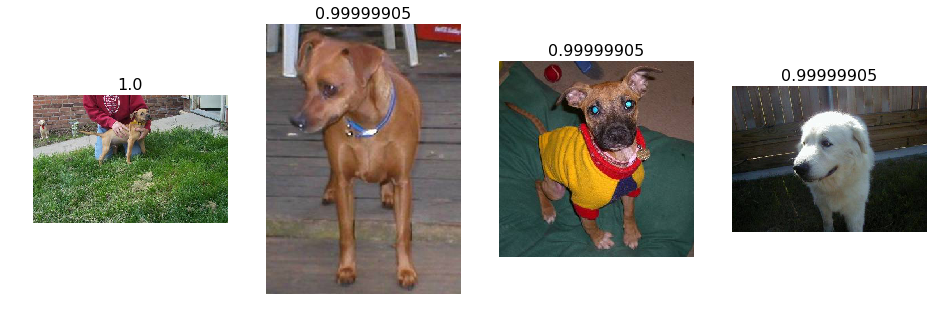

In [26]:
plot_val_with_title(most_by_correct(1, True), "Most correct Dogs")

Most Incorrect Cats


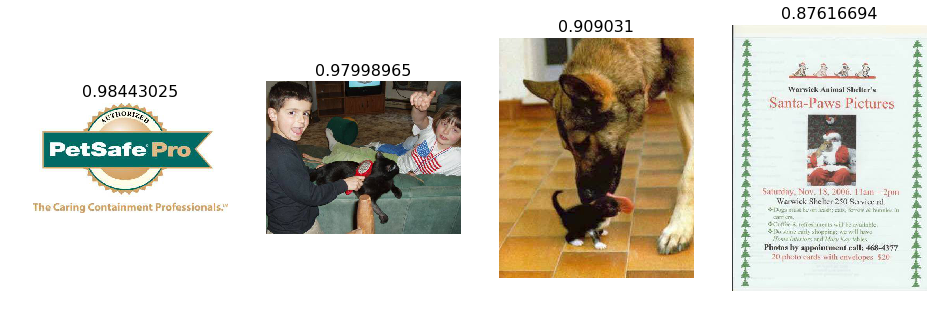

In [27]:
plot_val_with_title(most_by_correct(0, False), "Most Incorrect Cats")

Most Incorrect Dogs


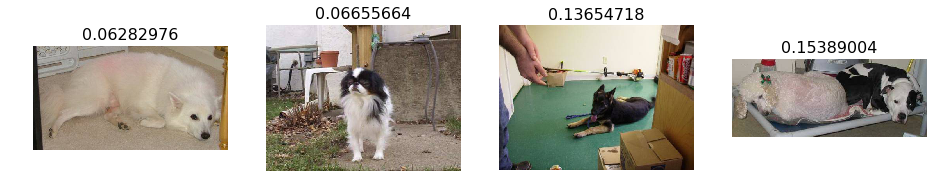

In [28]:
plot_val_with_title(most_by_correct(1, False), "Most Incorrect Dogs")

Most uncertain predictions


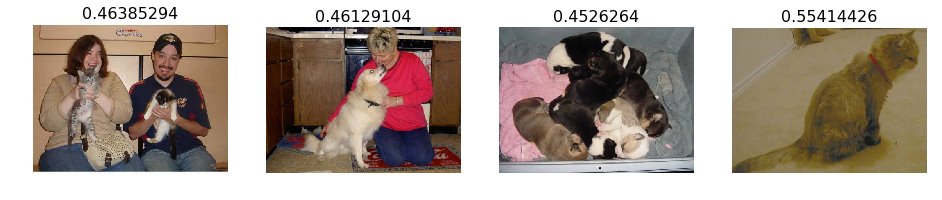

In [29]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [30]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [31]:
lrf = learn.lr_find()

 82%|████████▏ | 296/360 [00:05<00:01, 60.61it/s, loss=0.416]


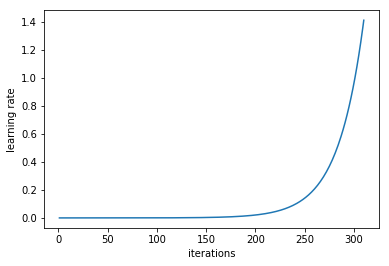

In [32]:
learn.sched.plot_lr()

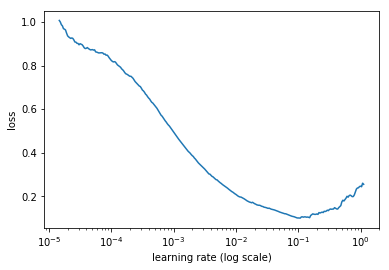

In [33]:
learn.sched.plot()

### Data Augmentation

In [40]:
# The below 3 lines of code is for seeing how the data augmentation works.

In [15]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [16]:
def get_augs():
    data = ImageClassifierData.from_paths(path=PATH, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

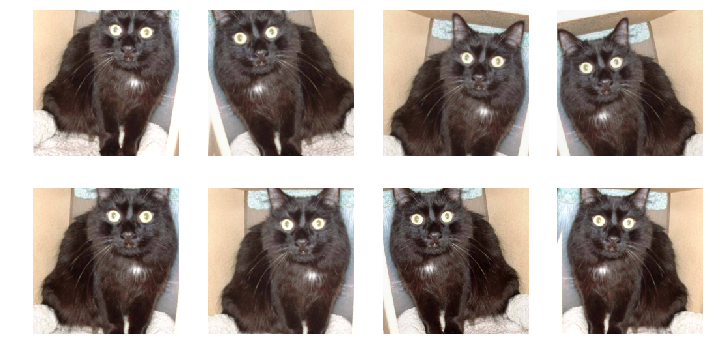

In [17]:
ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

In [22]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 103306212.51it/s]


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


In [23]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.052896   0.03301    0.9905    



[array([0.03301]), 0.9905]

In [24]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to frozen. That means that it's still only updating the weights in the last layer when we call fit.

In [25]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.043578   0.025132   0.99      
    1      0.046759   0.024472   0.9895    
    2      0.052726   0.023602   0.9915    



[array([0.0236]), 0.9915]

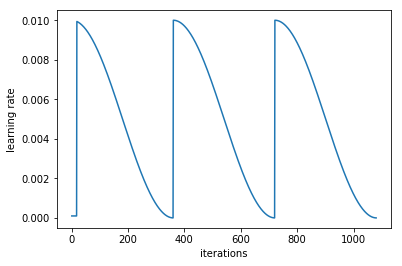

In [26]:
learn.sched.plot_lr()

In [27]:
learn.save('224_lastlayer')

In [28]:
os.getcwd()

'/content/clouderizer/fast.ai/fastai/courses/dl1'

In [29]:
learn.load('224_lastlayer')

In [30]:
learn.unfreeze()

In [31]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [32]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.04996    0.024861   0.991     
    1      0.038033   0.020769   0.9925    
  0%|          | 0/360 [00:00<?, ?it/s]

KeyboardInterrupt: 